<a href="https://colab.research.google.com/github/VictorComitti/IBMEC_IA_FINAN-AS/blob/main/Python/series_temporais/aula_04_series_temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
import matplotlib.dates as mdates


Vamos usar como exemplo a série histórica do IPCA. Podemos carregar os dados diretamente no python via API do banco central

In [ ]:
url = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.433/dados?formato=csv"
ipca = pd.read_csv(url, sep=";", decimal=",")
ipca.columns = ["ds", "y"]
ipca["ds"] = pd.to_datetime(ipca["ds"], format="%d/%m/%Y")
ipca["y"] = ipca["y"].astype(float)




Vamos usar dados posteriores a 2010 apenas

In [ ]:
ipca = ipca[ipca["ds"] >= "2010-01-01"]
ipca

,ds,y
359,2010-01-01,0.75
360,2010-02-01,0.78
361,2010-03-01,0.52
362,2010-04-01,0.57
363,2010-05-01,0.43
...,...,...
539,2025-01-01,0.16
540,2025-02-01,1.31
541,2025-03-01,0.56
542,2025-04-01,0.43


Visualização da série temporal

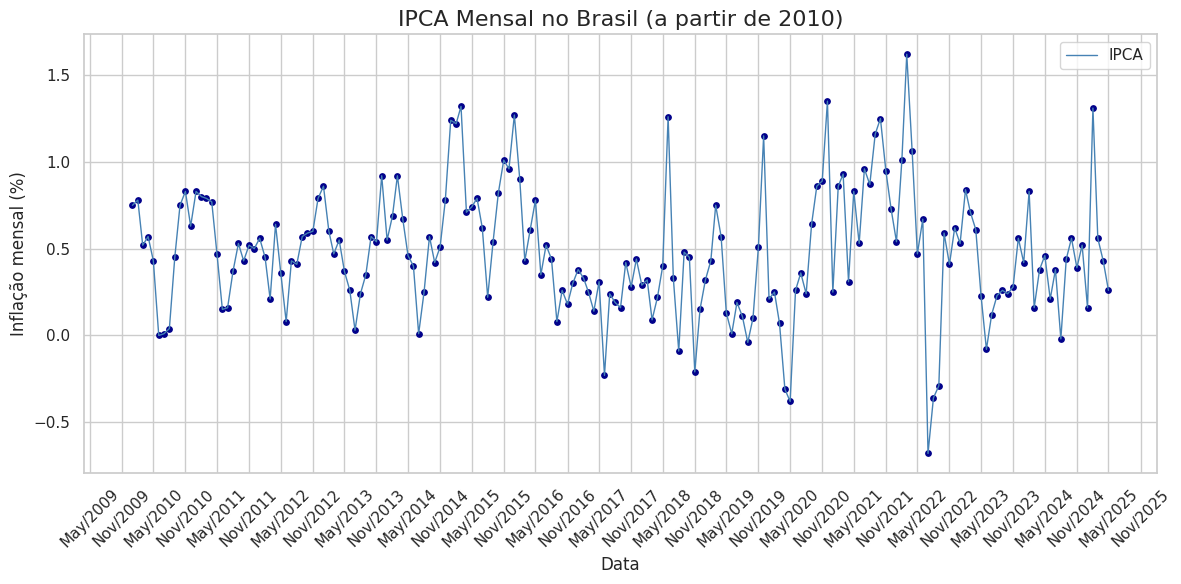

In [ ]:
# Definindo Estilo

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

#Definindo tipo de plot

fig, ax = plt.subplots()
ax.plot(ipca["ds"], ipca["y"], color="steelblue", linewidth=1, label="IPCA")
ax.scatter(ipca["ds"], ipca["y"], color="darkblue", s=15)

# Formatação do eixo x
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # mostra todos os meses
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))  # formato abreviado: Jan/2010
plt.xticks(rotation=45)

# Títulos e rótulos
plt.title("IPCA Mensal no Brasil (a partir de 2010)", fontsize=16)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Inflação mensal (%)", fontsize=12)
plt.tight_layout()
plt.legend()
plt.show()

Antes de começar a modelagem, vamos decompor a série temporal em componentes não observáveis.

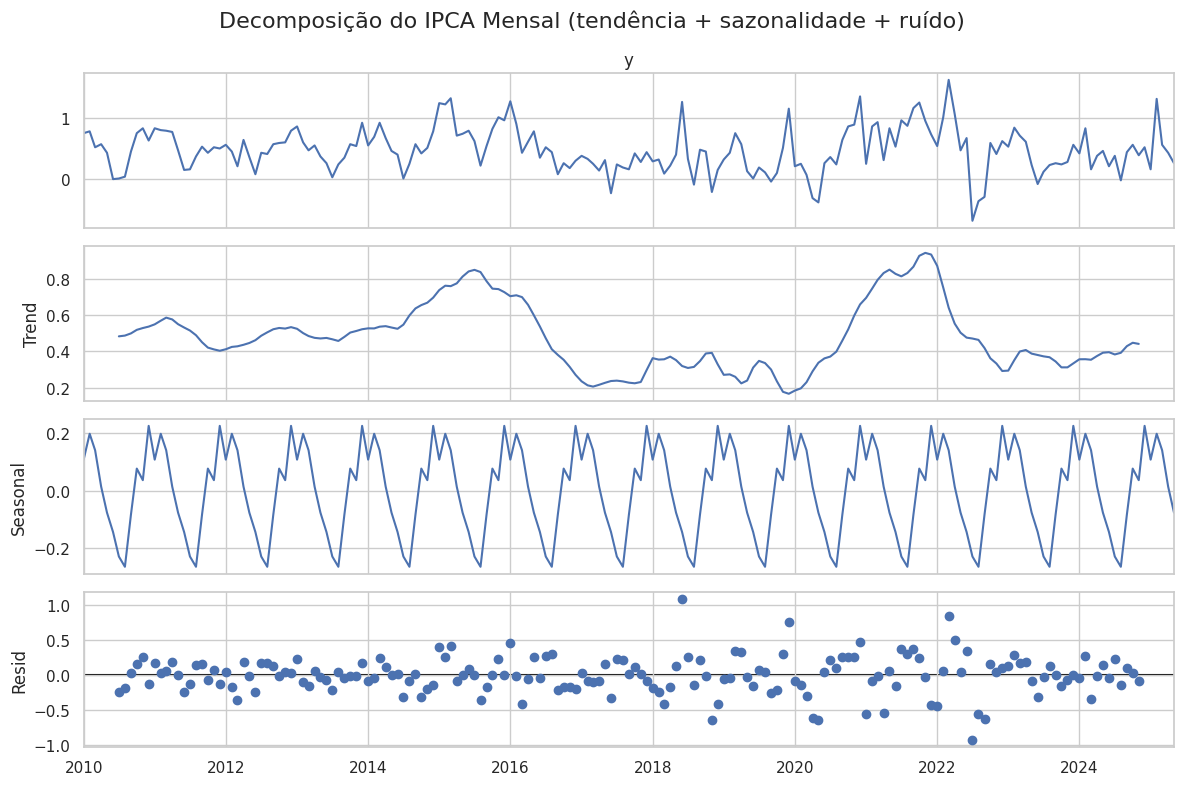

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose


# A série precisa estar com índice temporal
ipca_decomposicao = ipca.copy()
ipca_decomposicao.set_index("ds", inplace=True)

# Aplicar decomposição aditiva (assume: série = tendência + sazonalidade + ruído)
resultado = seasonal_decompose(ipca_decomposicao["y"], model="additive", period=12)

# 5. Plot da decomposição
fig = resultado.plot()
fig.set_size_inches(12, 8)
fig.suptitle("Decomposição do IPCA Mensal (tendência + sazonalidade + ruído)", fontsize=16)
plt.tight_layout()
plt.show()

O fato de que a série temporal tem uma sazonalidade bem definida já indica que ela não é estacionária.

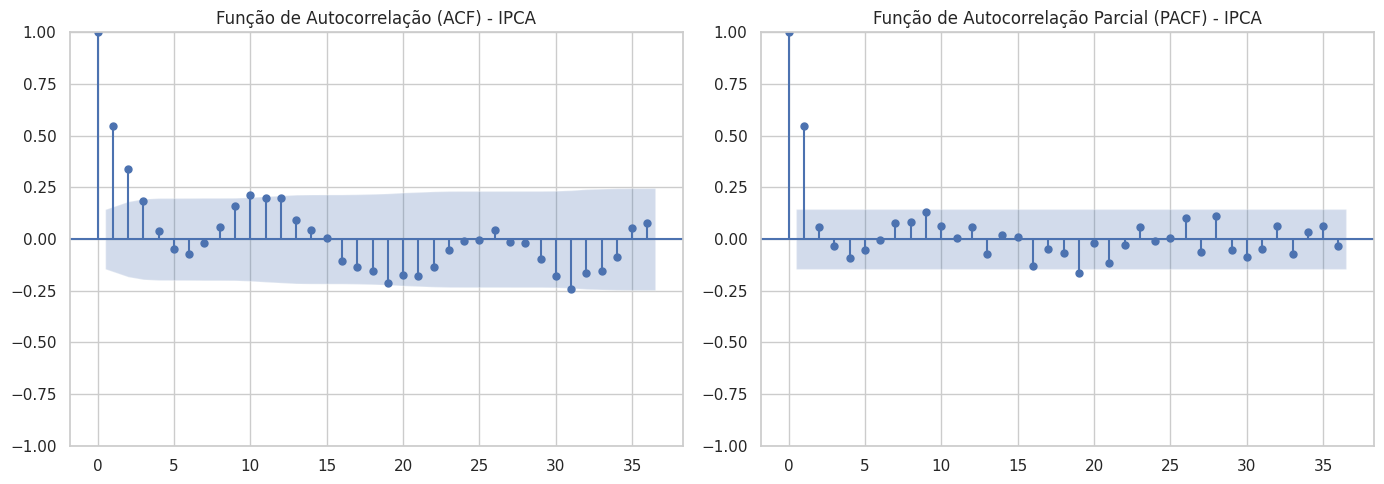

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Criar figura com dois subgráficos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF
plot_acf(ipca["y"], lags=36, ax=axes[0])
axes[0].set_title("Função de Autocorrelação (ACF) - IPCA")

# PACF
plot_pacf(ipca["y"], lags=36, ax=axes[1], method="ywm")  # 'ywm' é estável para dados econômicos
axes[1].set_title("Função de Autocorrelação Parcial (PACF) - IPCA")

plt.tight_layout()
plt.show()



*   ACF com picos a cada 12 meses: forte sazonalidade anual.
*   Decaimento lento na ACF: indício de não estacionariedade.
*   PACF com corte abrupto: sugere o valor de p para modelos AR.
*   ACF com corte e PACF decaindo: sugere modelo MA.


Pelas figuras há um padrão sazonal claro. A ACF parece decair exponencialmente e a PACF trava no segundo lag. Vamos tentar inicialmente um modelo SARIMA (2,1,0), (1, 0, 0)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Copia a série
ipca_sarima = ipca.copy()

# Força o índice com frequência reconhecida
ipca_sarima.index = pd.date_range(
    start=ipca["ds"].min(),
    periods=len(ipca),
    freq="MS"  # Month Start = início de cada mês
)

ipca_sarima.drop(columns="ds", inplace=True)

# Ajustar o modelo SARIMA(2,1,0)(1,0,0,12)
modelo_sarima = SARIMAX(
    ipca_sarima["y"],
    order=(2, 1, 0),
    seasonal_order=(1, 0, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultado_sarima = modelo_sarima.fit(disp=False)

# Sumário do modelo
print(resultado_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  185
Model:             SARIMAX(2, 1, 0)x(1, 0, 0, 12)   Log Likelihood                 -53.020
Date:                            Mon, 16 Jun 2025   AIC                            114.040
Time:                                    02:35:26   BIC                            126.584
Sample:                                01-01-2010   HQIC                           119.130
                                     - 05-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3311      0.073     -4.532      0.000      -0.474      -0.188
ar.L2         -0.1582      0.074   

Vamos interpretar essa saída:


*   ar.L1 = -0.33	O valor atual do IPCA depende negativamente do mês anterior.
*   ar.L2 = -0.16	Também há dependência negativa com o valor de 2 meses atrás.
*   ar.S.L12 = +0.14	Existe componente sazonal anual fraco
*   sigma2 = 0.11	Variância dos resíduos, relativamente baixa.
*   AIC = 114 → bom para comparação com outros modelos.
*   Jarque-Bera = 36.03 com p < 0.01 → resíduos não são normais.
*   Ljung-Box (Q) = 0.84 → não há autocorrelação de 1ª ordem nos resíduos → bom sinal



Agora podemos calcular previsões para seis meses à frente.

In [ ]:
previsao = resultado_sarima.get_forecast(steps=6)
ic = previsao.conf_int()

# Previsões associadas a datas corretamente
previsoes_df = previsao.summary_frame()
print(previsoes_df.head())


y               mean   mean_se  mean_ci_lower  mean_ci_upper
2025-06-01  0.310881  0.330526      -0.336937       0.958700
2025-07-01  0.334675  0.397651      -0.444707       1.114056
2025-08-01  0.265997  0.447398      -0.610887       1.142882
2025-09-01  0.333757  0.501991      -0.650128       1.317642
2025-10-01  0.350956  0.549176      -0.725410       1.427321


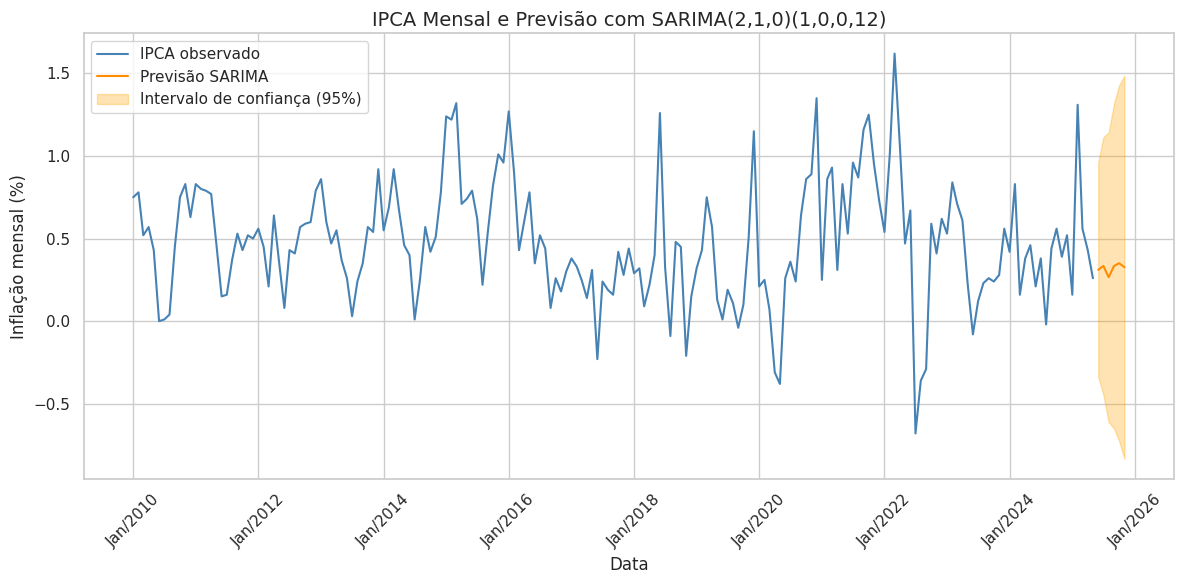

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Converte datas e valores para tipos compatíveis com matplotlib
x_prev = previsoes_df.index.to_pydatetime()
y_mean = previsoes_df["mean"].astype(float).values
y_lower = previsoes_df["mean_ci_lower"].astype(float).values
y_upper = previsoes_df["mean_ci_upper"].astype(float).values
y_hist = ipca_sarima["y"].astype(float).values

# Gerar o gráfico
plt.figure(figsize=(12, 6))

# Série histórica
plt.plot(ipca_sarima.index, y_hist, label="IPCA observado", color="steelblue")

# Previsão
plt.plot(x_prev, y_mean, label="Previsão SARIMA", color="darkorange")
plt.fill_between(x_prev, y_lower, y_upper, color="orange", alpha=0.3, label="Intervalo de confiança (95%)")

# Formatação do eixo X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
plt.xticks(rotation=45)

# Títulos e legendas
plt.title("IPCA Mensal e Previsão com SARIMA(2,1,0)(1,0,0,12)", fontsize=14)
plt.xlabel("Data")
plt.ylabel("Inflação mensal (%)")
plt.legend()
plt.tight_layout()
plt.show()



Para encontrar o melhor modelo, podemos tentar um processo de força bruta no qual testamos diversas combinações p e q e comparamos os modelos resultantes pelo AIC.

In [ ]:
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Evita mostrar mensagens de warning durante o grid search
warnings.filterwarnings("ignore")

# Parâmetros a testar
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 12  # Sazonalidade mensal

# Combinações de parâmetros não sazonais e sazonais
param = list(itertools.product(p, d, q))
param_sazonal = list(itertools.product(P, D, Q))

# Variáveis para armazenar o melhor modelo
melhor_modelo = None
melhor_aic = float("inf")
melhor_ordem = None
melhor_sazonal = None

# Loop pelos modelos
for ordem in param:
    for sazonal in param_sazonal:
        sazonal_ajuste = sazonal + (s,)
        try:
            modelo = SARIMAX(
                ipca_sarima["y"],
                order=ordem,
                seasonal_order=sazonal_ajuste,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            resultado = modelo.fit(disp=False)
            if resultado.aic < melhor_aic:
                melhor_aic = resultado.aic
                melhor_modelo = resultado
                melhor_ordem = ordem
                melhor_sazonal = sazonal_ajuste
        except:
            continue

# Exibir os melhores parâmetros encontrados
print(f"Melhor SARIMA: ordem={melhor_ordem}, sazonal={melhor_sazonal}, AIC={melhor_aic:.2f}")
print(melhor_modelo.summary())

Melhor SARIMA: ordem=(1, 1, 1), sazonal=(1, 0, 0, 12), AIC=91.52
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  185
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                 -41.758
Date:                             Mon, 16 Jun 2025   AIC                             91.516
Time:                                     02:41:22   BIC                            104.082
Sample:                                 01-01-2010   HQIC                            96.615
                                      - 05-01-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5274      0.062      8.4

Por fim, vamos comparar o modelo inicial com o melhor modelo encontrado pelo método de força bruta em termos de erro de previsão.

In [ ]:
# Separar a série em treino e teste
n_test = 6
ipca_treino = ipca_sarima.iloc[:-n_test]
ipca_teste = ipca_sarima.iloc[-n_test:]


In [ ]:

# Reajusta o primeiro modelo considerando a janela menor de dados
modelo_manual = SARIMAX(
    ipca_treino["y"],
    order=(2, 1, 0),
    seasonal_order=(1, 0, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultado_manual = modelo_manual.fit(disp=False)

previsao_manual = resultado_manual.get_forecast(steps=n_test)
prev_manual_df = previsao_manual.summary_frame()

In [ ]:
# fazemos o mesmo para o modelo de força bruta

modelo_auto = SARIMAX(
    ipca_treino["y"],
    order=melhor_ordem,
    seasonal_order=melhor_sazonal,
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultado_auto = modelo_auto.fit(disp=False)

previsao_auto = resultado_auto.get_forecast(steps=n_test)
prev_auto_df = previsao_auto.summary_frame()

In [ ]:
from sklearn.metrics import mean_squared_error
# Agora comparamos erros de previsão
y_real = ipca_teste["y"].values
rmse_manual = np.sqrt(mean_squared_error(y_real, prev_manual_df["mean"]))
rmse_auto = np.sqrt(mean_squared_error(y_real, prev_auto_df["mean"]))

print(f"RMSE (manual):    {rmse_manual:.3f}")
print(f"RMSE (automático):{rmse_auto:.3f}")

RMSE (manual):    0.371
RMSE (automático):0.365


O RMSE mostra que o modelo de 'força bruta' gera previsões mais precisas. O gráfico abaixo mostra as previsões considerando ambos os modelos.

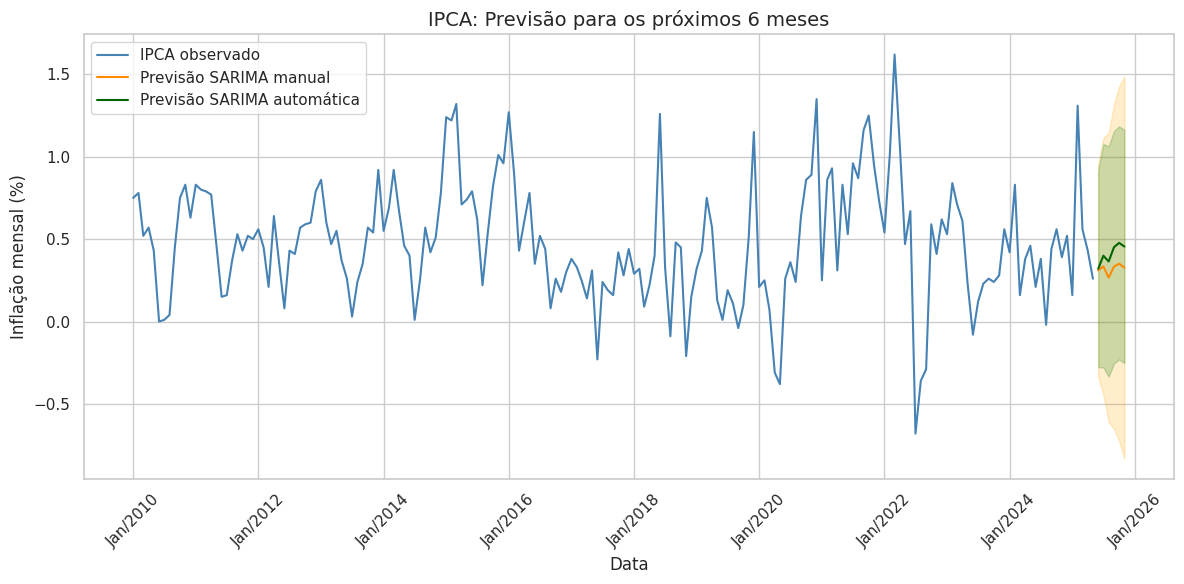

In [ ]:
# Passo 1: Previsões para os 6 meses seguintes

previsao_manual_final = resultado_sarima.get_forecast(steps=6)
prev_manual_df = previsao_manual_final.summary_frame()

previsao_auto_final = melhor_modelo.get_forecast(steps=6)
prev_auto_df = previsao_auto_final.summary_frame()

# Datas futuras
datas_futuras = pd.date_range(
    start=ipca_sarima.index[-1] + pd.offsets.MonthBegin(),
    periods=6,
    freq="MS"
)

# Passo 2: Gráfico comparativo

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))

# Série histórica
plt.plot(ipca_sarima.index, ipca_sarima["y"], label="IPCA observado", color="steelblue")

# Previsões - Manual
plt.plot(datas_futuras, prev_manual_df["mean"], label="Previsão SARIMA manual", color="darkorange")
plt.fill_between(
    datas_futuras,
    prev_manual_df["mean_ci_lower"],
    prev_manual_df["mean_ci_upper"],
    color="orange",
    alpha=0.2
)

# Previsões - Automático
plt.plot(datas_futuras, prev_auto_df["mean"], label="Previsão SARIMA automática", color="darkgreen")
plt.fill_between(
    datas_futuras,
    prev_auto_df["mean_ci_lower"],
    prev_auto_df["mean_ci_upper"],
    color="green",
    alpha=0.2
)

# Formatação de datas no eixo x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
plt.xticks(rotation=45)

# Título e eixos
plt.title("IPCA: Previsão para os próximos 6 meses", fontsize=14)
plt.xlabel("Data")
plt.ylabel("Inflação mensal (%)")
plt.legend()
plt.tight_layout()
plt.show()

